# Кредитный скоринг

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, norm

In [2]:
df = pd.read_csv('credit_card_default_analysis.csv')
df.shape

(30000, 25)

In [3]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
df.dropna().shape

(30000, 25)

In [5]:
np.unique(df.default)

array([0, 1])

Разделяем данные по признаку невозврата денежных средств

In [6]:
df0, df1 = [df[df.default == i] for i in range(2)]
df0.shape[0], df1.shape[0]

(23364, 6636)

## Задание 1. Размер кредитного лимита

In [7]:
lb0, lb1 = [dd.LIMIT_BAL for dd in [df0, df1]]

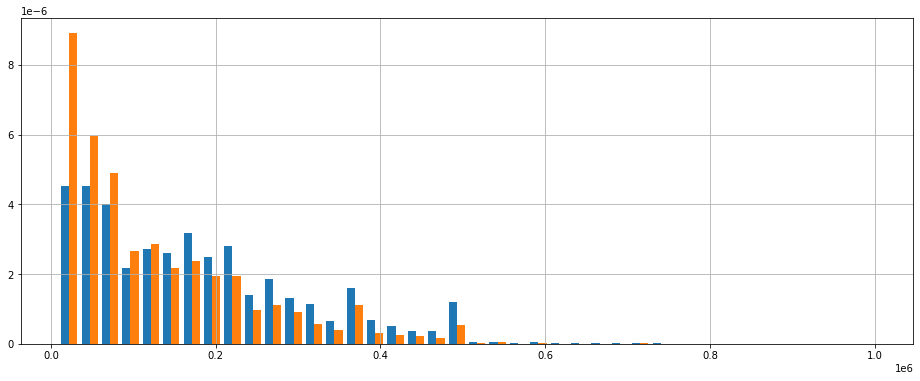

In [8]:
plt.figure(figsize=(16, 6))
plt.hist([lb0, lb1], bins=40, density=True);
plt.grid()

Видно, что в левые бины для второго набора больше, чем для первого, а правые - наоборот. Эффект не очень большой, но похож на значимый.

### 1a. Интервальная оценка для медиан
Построим 95% квантильные интервалы

In [9]:
pval = 0.05
lo0, hi0 = np.quantile(lb0, [pval / 2, 1. - pval / 2])
lo0, hi0

(20000.0, 500000.0)

In [10]:
lo1, hi1 = np.quantile(lb1, [pval / 2, 1. - pval / 2])
lo1, hi1

(10000.0, 440000.0)

Интервалы сильно перекрываются, поэтому простая интервальная оценка не позволяет сделать вывод о том, что кредитный лимир различается для двух групп данных

### 1b. Непараметрический критерий для средних
Данные независимые, поэтому используем критерий Манни-Уитни.

Нулевая гипотеза: средние значения равны

Альтернативная гипотеза: средние значения не равны

In [11]:
mannwhitneyu(lb0, lb1, alternative='two-sided')

MannwhitneyuResult(statistic=95786286.5, pvalue=1.2255485818223303e-189)

Достогнут уровень значимости pvalue=1.2e-189. Для порога 0.05 нулевая гипотеза отвергается.

In [12]:
print(f'{lb0.mean():.2f} +- {lb0.std():.2f} vs. {lb1.mean():.2f} +- {lb1.std():.2f}')

178099.73 +- 131628.36 vs. 130109.66 +- 115378.54


In [13]:
(lb0.mean() - lb1.mean()) / lb0.std()

0.3645876145425937

In [14]:
lb0.mean() / lb1.mean()

1.3688432586435533

Критерий Манни-Уитни выдает очень высокий уровень значимости различия средних значений. С практической точки зрения значимость небольшая: отношение средних равно всего 1.37, а их разность почти в три раза меньше среднеквадратичного отклонения.

## Задание 2. Пол

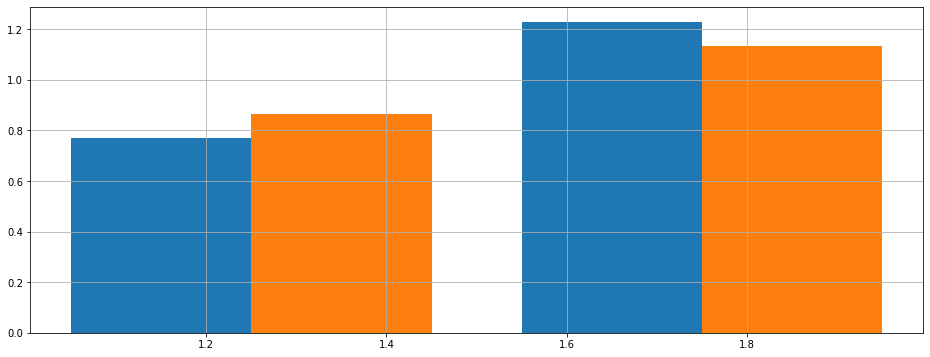

In [15]:
plt.figure(figsize=(16, 6))
plt.hist([df0.SEX, df1.SEX], bins=2, density=True);
plt.grid()

Относительная доля мужчин во втором наборе выше. Выясним насколько значимо это отличие.

### 2a. Интервальная оценка
Начнем с вычисления среднего и дисперсии для биномиального распределения

In [16]:
p0 = np.sum(df0.SEX == 1) / df0.shape[0]
p1 = np.sum(df1.SEX == 1) / df1.shape[0]
p0, p1

(0.38585002568053417, 0.43294153104279687)

In [17]:
std0 = np.sqrt(p0 * (1 - p0) / df0.shape[0]) 
std1 = np.sqrt(p1 * (1 - p1) / df1.shape[0])
std0, std1

(0.0031847319655347187, 0.006082405303069922)

In [18]:
z = 2
(p0 - z * std0, p0 + z * std0), (p1 - z * std1, p1 + z * std1)

((0.3794805617494647, 0.39221948961160363),
 (0.42077672043665704, 0.4451063416489367))

Интервалы для z = 2 не перекрываются. Распределения можно считать значимо разными.

### 2b. Параметрический критерий для доли
Выборки независимые, поэтому применяем соответсвующий критерий для доли.

Нулевая гитопеза: p1 = p2

Альтернативная гипотеза: p1 != p2

In [19]:
def frac_diff(n1, p1, n2, p2, prob):
    z = norm.ppf(prob + 0.5 * (1 - prob))
    sigma = z * np.sqrt(p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2)
    return p1 - p2 - sigma, p1 - p2 + sigma

In [20]:
lo, hi = frac_diff(df0.shape[0], p0, df1.shape[0], p1, 0.95)
print(f'{lo:.3f} {hi:.3f}')

-0.061 -0.034


Интервал не содержит ноль, значит нулевая гипотеза отклоняется на уровне значимости 0.05. На самом деле достигаемы кровень значимости намного выше:

In [21]:
lo, hi = frac_diff(df0.shape[0], p0, df1.shape[0], p1, 1 - 1e-10)
print(f'{lo:.3f} {hi:.3f}')

-0.091 -0.003


## Задание 3. Образование
Разделим данные по признаку образования

In [22]:
edudfs = [df[df.EDUCATION == i].default for i in range(7)]

Визуализируем данные следующим образом. Для каждого набора посчитаем наблюдаемую долю невозвратов (`means`) и соответсвующие стандартные отклонения для биномиального распределения $np(1-p)$. Полученные значения нарисуем на графике с ошибками.

array([   14, 10585, 14030,  4917,   123,   280,    51])

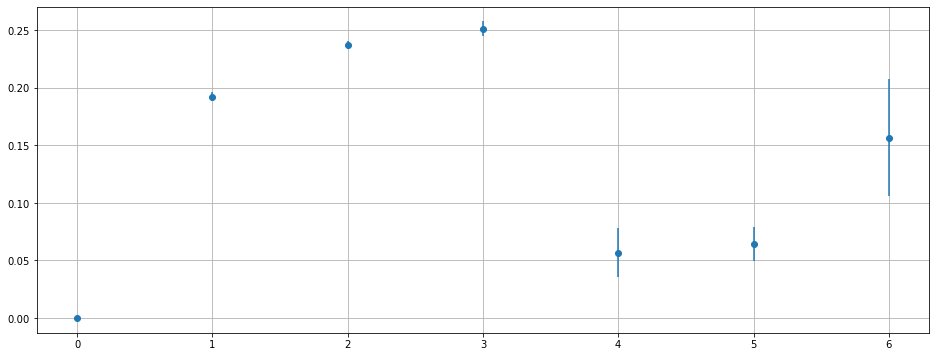

In [23]:
plt.figure(figsize=(16, 6))
means = np.array(list(map(np.mean, edudfs)))
counts = np.array(list(map(lambda x: x.size, edudfs)))
sigmas = np.sqrt(means * (1 - means) / counts)
plt.errorbar(np.arange(7), means, yerr=sigmas, fmt='o');
plt.grid()
counts

Видно, что категории образования 0, 1, 2, 3 значимо отличаются друг от друга. Полагаю, что таблицы сопраженности уже не нужны, все и так ясно. Докторская степень (значение 0) гарантирует возврат долга. Четверть выпускников школ (3) и бакалавров (2) не возвращают долг.

Приметим теперь для каждой пары наборов критерий для долей для независимых выборок (аналогично предыдущему заданию)

Нулевая гитопеза: p1 = p2

Альтернативная гипотеза: p1 != p2

In [24]:
prob = 0.95
for i, ddi in enumerate(edudfs):
    for j, ddj in enumerate(edudfs):
        if i <= j:
            continue
        lo, hi = frac_diff(ddi.shape[0], ddi.mean(), ddj.shape[0], ddj.mean(), prob)
        if lo * hi > 0:
            print(f'({i}, {j}): {lo:+.3f} {hi:+.3f} significant')

(1, 0): +0.185 +0.200 significant
(2, 0): +0.230 +0.244 significant
(2, 1): +0.035 +0.055 significant
(3, 0): +0.239 +0.264 significant
(3, 1): +0.045 +0.073 significant
(3, 2): +0.000 +0.028 significant
(4, 0): +0.016 +0.098 significant
(4, 1): -0.177 -0.094 significant
(4, 2): -0.222 -0.139 significant
(4, 3): -0.237 -0.152 significant
(5, 0): +0.036 +0.093 significant
(5, 1): -0.158 -0.098 significant
(5, 2): -0.203 -0.143 significant
(5, 3): -0.218 -0.156 significant
(6, 0): +0.057 +0.257 significant


In [25]:
for i, ddi in enumerate(edudfs):
    for j, ddj in enumerate(edudfs):
        if i <= j:
            continue
        lo, hi = frac_diff(ddi.shape[0], ddi.mean(), ddj.shape[0], ddj.mean(), prob)
        if lo * hi < 0:
            print(f'({i}, {j}): {lo:+.3f} {hi:+.3f} not significant')

(5, 4): -0.043 +0.057 not significant
(6, 1): -0.136 +0.065 not significant
(6, 2): -0.181 +0.020 not significant
(6, 3): -0.195 +0.006 not significant
(6, 4): -0.008 +0.208 not significant
(6, 5): -0.011 +0.196 not significant


Таким образом, на уровне значимости 0.05 мы отличаем все уровни образования кроме (5, 4) и 6 относительно всех кроме нулевой. Полученные результаты согласуются с интуицией, полученной по графику выше. Увеличим уровень значимости до `1. - 1e-10` и посмотрим какие пары останутся

In [26]:
prob = 1. - 1e-10
for i, ddi in enumerate(edudfs):
    for j, ddj in enumerate(edudfs):
        if i <= j:
            continue
        lo, hi = frac_diff(ddi.shape[0], ddi.mean(), ddj.shape[0], ddj.mean(), prob)
        if lo * hi > 0:
            print(f'({i}, {j}): {lo:+.3f} {hi:+.3f} significant')

(1, 0): +0.168 +0.217 significant
(2, 0): +0.214 +0.261 significant
(2, 1): +0.011 +0.079 significant
(3, 0): +0.212 +0.292 significant
(3, 1): +0.012 +0.106 significant
(4, 2): -0.318 -0.043 significant
(4, 3): -0.336 -0.054 significant
(5, 1): -0.226 -0.030 significant
(5, 2): -0.271 -0.075 significant
(5, 3): -0.290 -0.084 significant


## Задание 4. Семейное положение
Повторяем ту же процедуру для семейного положения.

In [27]:
mardfs = [df[df.MARRIAGE == i].default for i in range(4)]

array([   54, 13659, 15964,   323])

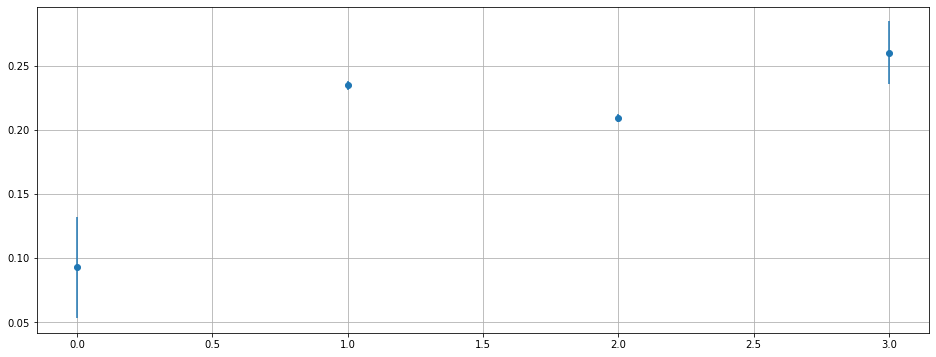

In [28]:
plt.figure(figsize=(16, 6))
means = np.array(list(map(np.mean, mardfs)))
counts = np.array(list(map(lambda x: x.size, mardfs)))
sigmas = np.sqrt(means * (1 - means) / counts)
plt.errorbar(np.arange(4), means, yerr=sigmas, fmt='o');
plt.grid()
counts

Женатые/замужние (1) значимо чаще задерживают платежи, чем холостые (2)

In [29]:
prob = 0.95
for i, ddi in enumerate(mardfs):
    for j, ddj in enumerate(mardfs):
        if i <= j:
            continue
        lo, hi = frac_diff(ddi.shape[0], ddi.mean(), ddj.shape[0], ddj.mean(), prob)
        if lo * hi > 0:
            print(f'({i}, {j}): {lo:+.3f} {hi:+.3f} significant')

(1, 0): +0.064 +0.220 significant
(2, 0): +0.039 +0.194 significant
(2, 1): -0.035 -0.016 significant
(3, 0): +0.077 +0.258 significant
(3, 2): +0.003 +0.099 significant


Выводы для уровня значимости 0.05:

1. Те, кто отказались отвечать (0) значимо лучше, чем все остальные (1, 2, 3), возвращают долг
2. Женатые/замужние (1) значимо чаще задерживают платежи, чем, холостые (2)
3. Те, для кого нет данных (3), значимо чаще задерживают платежи, чем холостые (2)

### Связь переменных. Вариант 1: фит полиномом (можно не смотреть)

Аппроксимируем точки на графике с помощью полинома:

In [30]:
from numpy.polynomial import chebyshev

Chebyshev([ 0.20201829,  0.04945447, -0.02569104,  0.03428019], domain=[0., 3.], window=[-1.,  1.])

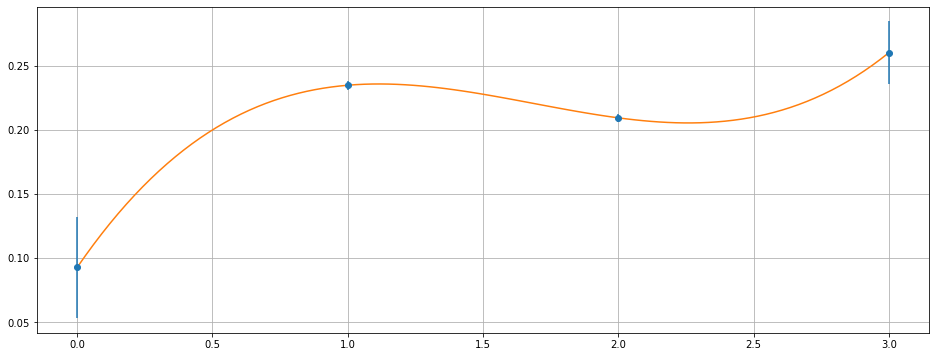

In [31]:
means = np.array(list(map(np.mean, mardfs)))
counts = np.array(list(map(lambda x: x.size, mardfs)))
sigmas = np.sqrt(means * (1 - means) / counts)
poly1 = chebyshev.Chebyshev.fit(np.arange(4), means, deg=3)

plt.figure(figsize=(16, 6))
plt.errorbar(np.arange(4), means, yerr=sigmas, fmt='o');
x = np.linspace(0, 3, 100)
plt.plot(x, poly1(x))
plt.grid()
poly1

### Связь переменных. Вариант 1: корреляция
Для графика выше можно применить корреляцию Пирсона

In [32]:
from scipy.stats import pearsonr, chi2_contingency
# from sklearn.metrics import matthews_corrcoef

In [33]:
pearsonr(np.arange(4), means)

(0.8320107893356514, 0.16798921066434858)

Выполним тест chi2 для матрицы смежности, оставив только замужних/женатых (1) и холостых (2). Это будет нашей лучшей мерой связи параметров.

Нулевая гипотеза: корреляция Мэтьюса = 0

Альтернатива: корреляция Мэтьюса != 0

In [34]:
contmtx = np.empty((2, 2), dtype=int)
for dflag in range(2):
    for marr in range(1, 3):
        contmtx[dflag, marr - 1] = df[(df.default == dflag) & (df.MARRIAGE == marr)].shape[0]
contmtx

array([[10453, 12623],
       [ 3206,  3341]])

In [35]:
chi2, pvalue, _, _ = chi2_contingency(contmtx)
chi2, pvalue

(27.5094090929579, 1.5633210355976673e-07)

Получили значимую корреляцию на уровне значимости 1.56e-7

Для полной матрицы посчитаем V-коэффициент Крамера

In [36]:
contmtx = np.empty((2, 4), dtype=int)
for dflag in range(2):
    for marr in range(4):
        contmtx[dflag, marr] = df[(df.default == dflag) & (df.MARRIAGE == marr)].shape[0]
contmtx

array([[   49, 10453, 12623,   239],
       [    5,  3206,  3341,    84]])

In [37]:
def vkramer(chi2, n, k1, k2):
    return np.sqrt(chi2 / (n * (min(k1, k2) - 1)))

In [38]:
vkramer(chi2, contmtx.sum(), 2, 4)

0.030281682633212386

Близкое к нулю значение соответсвует низкой корреляции

## Задание 5. Возраст

In [39]:
age0, age1 = [dd.AGE for dd in [df0, df1]]

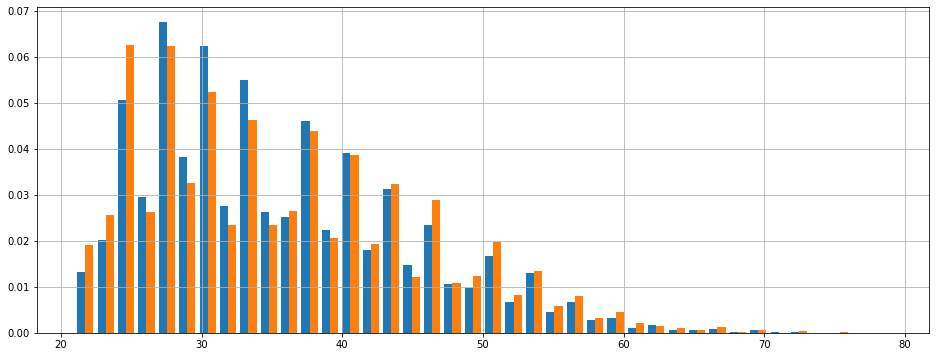

In [40]:
plt.figure(figsize=(16, 6))
plt.hist([age0, age1], bins=40, density=True);
plt.grid()

На глаз тружно заметить значимые отличия. Одно из наблюдений: в первых трех бинах (молодые люди) доля задержек платежей выше.

### 5a. Интервальная оценка

In [41]:
pval = 0.05
lo0, hi0 = np.quantile(age0, [pval / 2, 1. - pval / 2])
lo0, hi0

(23.0, 56.0)

In [42]:
pval = 0.05
lo1, hi1 = np.quantile(age1, [pval / 2, 1. - pval / 2])
lo1, hi1

(22.0, 57.0)

95% интерваты перекрываются почти полностью. Нельзя отвергнуть гипотзу о том, что медианные значения возраста одинаковые

### 5b. Непараметрический критерий для средних
Данные независимые, поэтому используем критерий Манни-Уитни.

Нулевая гипотеза: средние значения равны

Альтернативная гипотеза: средние значения не равны

In [43]:
mannwhitneyu(age0, age1, alternative='two-sided')

MannwhitneyuResult(statistic=76966879.5, pvalue=0.3725035434898616)

Видно, что отличие не значимо статистически. Поэтому с практической точки зрения различие также не значимо